In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.io as pio
import seaborn as sns
from collections import Counter
import os

In [3]:
# For sentiment analysis
try:
# prefer vader from nltk
   from nltk.sentiment.vader import SentimentIntensityAnalyzer
   import nltk
   nltk.download('vader_lexicon')
except Exception:
   SentimentIntensityAnalyzer = None

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Bansi\AppData\Roaming\nltk_data...


In [4]:
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 200)

In [7]:
# --- File paths (edit if needed) ---
file1 = r'D:\seda\SEDA Experiment\datasets\apps.csv'
file2 = r'D:\seda\SEDA Experiment\datasets\user_reviews.csv'

In [8]:
# Load safely (try both; detect which is main app dataset)
print('Files exist? ', os.path.exists(file1), os.path.exists(file2))

Files exist?  True True


In [9]:
# Try to load both — if one fails, you'll get an error to fix path
try:
   df1 = pd.read_csv(file1)
   print('Loaded file1 shape:', df1.shape)
except Exception as e:
   print('Failed loading file1:', e)
   df1 = None


try:
   df2 = pd.read_csv(file2)
   print('Loaded file2 shape:', df2.shape)
except Exception as e:
   print('Failed loading file2:', e)
   df2 = None

Loaded file1 shape: (9659, 14)
Loaded file2 shape: (64295, 5)


In [10]:
# Decide which is main apps table (heuristics)
candidate = None
for df in [df1, df2]:
  if df is None:
     continue
  cols = set(df.columns.str.lower())
# common play store columns
  if {'app','category','rating','reviews','size','installs','type','price'}.intersection(cols):
     candidate = df
     break


if candidate is None:
# fallback to first non-empty
   candidate = df1 if df1 is not None else df2


apps = candidate.copy()
print('\nSelected apps dataset shape:', apps.shape)
print('Columns:', apps.columns.tolist()[:40])


Selected apps dataset shape: (9659, 14)
Columns: ['Unnamed: 0', 'App', 'Category', 'Rating', 'Reviews', 'Size', 'Installs', 'Type', 'Price', 'Content Rating', 'Genres', 'Last Updated', 'Current Ver', 'Android Ver']


In [11]:
# --- Preview and initial sanity checks ---
print('\nPreview:')
display(apps.head())
print('\nInfo:')
display(apps.info())
print('\nMissing value counts:')
display(apps.isna().sum().sort_values(ascending=False).head(30))


Preview:


,Unnamed: 0,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19.0,"10,000+",Free,0,Everyone,Art & Design,"January 7, 2018",1.0.0,4.0.3 and up
1,1,Coloring book moana,ART_AND_DESIGN,3.9,967,14.0,"500,000+",Free,0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up
2,2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8.7,"5,000,000+",Free,0,Everyone,Art & Design,"August 1, 2018",1.2.4,4.0.3 and up
3,3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25.0,"50,000,000+",Free,0,Teen,Art & Design,"June 8, 2018",Varies with device,4.2 and up
4,4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2.8,"100,000+",Free,0,Everyone,Art & Design;Creativity,"June 20, 2018",1.1,4.4 and up



Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9659 entries, 0 to 9658
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Unnamed: 0      9659 non-null   int64  
 1   App             9659 non-null   object 
 2   Category        9659 non-null   object 
 3   Rating          8196 non-null   float64
 4   Reviews         9659 non-null   int64  
 5   Size            8432 non-null   float64
 6   Installs        9659 non-null   object 
 7   Type            9659 non-null   object 
 8   Price           9659 non-null   object 
 9   Content Rating  9659 non-null   object 
 10  Genres          9659 non-null   object 
 11  Last Updated    9659 non-null   object 
 12  Current Ver     9651 non-null   object 
 13  Android Ver     9657 non-null   object 
dtypes: float64(2), int64(2), object(10)
memory usage: 1.0+ MB


None


Missing value counts:


Rating            1463
Size              1227
Current Ver          8
Android Ver          2
App                  0
Unnamed: 0           0
Reviews              0
Category             0
Installs             0
Type                 0
Content Rating       0
Price                0
Last Updated         0
Genres               0
dtype: int64

In [23]:
# --- Cleaning helpers ---
import re
def parse_installs(x):
    if pd.isna(x):
       return np.nan
    try:
       if isinstance(x, (int,float)):
           return int(x)
       s = str(x).strip().lower()
       s = s.replace('+','').replace(',','').replace(' ', '')
       return int(re.sub(r'[^0-9]','', s)) if s!='' else np.nan
    except:
       return np.nan

def parse_price(x):
    if pd.isna(x):
       return 0.0
    try:
       s = str(x).strip()
       s = s.replace('$','').replace('â','')
       s = s.replace(',','')
       return float(re.sub(r'[^0-9\.\-]','', s)) if s!='' else 0.0
    except:
       return 0.0

def parse_size(x):
    # sizes can be '19M', '1.2M', 'Varies with device'
    if pd.isna(x):
       return np.nan
    s = str(x).strip()
    if s.lower().startswith('varies'):
        return np.nan
    s = s.replace(',','')
    m = re.match(r'([0-9\.]+)\s*([kKmMgG]?)', s)
    if not m:
    
        # maybe raw bytes
       try:
           return float(s)
       except:
           return np.nan
    val, unit = float(m.group(1)), m.group(2).lower()
    if unit == 'k':
       return val/1024
    if unit == 'm' or unit == '':
       return val
    if unit == 'g':
       return val*1024
    return val

In [24]:
# Normalize column names (lowercase, strip spaces)
apps.columns = [c.strip() for c in apps.columns]
colmap = {c: c.lower().strip().replace(' ','_') for c in apps.columns}
apps.rename(columns=colmap, inplace=True)

In [25]:
# Apply parsers to common columns if present
if 'installs' in apps.columns:
    apps['installs_clean'] = apps['installs'].apply(parse_installs)
if 'price' in apps.columns:
    apps['price_clean'] = apps['price'].apply(parse_price)
if 'size' in apps.columns:
    apps['size_mb'] = apps['size'].apply(parse_size)
if 'rating' in apps.columns:
    apps['rating'] = pd.to_numeric(apps['rating'], errors='coerce')
if 'reviews' in apps.columns:
# reviews might be string; convert
    apps['reviews'] = pd.to_numeric(apps['reviews'], errors='coerce')

In [27]:
# Standardize category column name
for candidate_col in ['category','genres','app_category','cat']:
    if candidate_col in apps.columns:
       apps.rename(columns={candidate_col:'category'}, inplace=True)
       break

In [28]:
# Drop exact duplicates
apps.drop_duplicates(subset=['app'] if 'app' in apps.columns else None, inplace=True)


print('\nAfter cleaning sample:')
display(apps.head())


After cleaning sample:


,unnamed:_0,app,category,rating,reviews,size,installs,type,price,content_rating,genres,last_updated,current_ver,android_ver,installs_clean,price_clean,size_mb
0,0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19.0,"10,000+",Free,0,Everyone,Art & Design,"January 7, 2018",1.0.0,4.0.3 and up,10000,0.0,19.0
1,1,Coloring book moana,ART_AND_DESIGN,3.9,967,14.0,"500,000+",Free,0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up,500000,0.0,14.0
2,2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8.7,"5,000,000+",Free,0,Everyone,Art & Design,"August 1, 2018",1.2.4,4.0.3 and up,5000000,0.0,8.7
3,3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25.0,"50,000,000+",Free,0,Teen,Art & Design,"June 8, 2018",Varies with device,4.2 and up,50000000,0.0,25.0
4,4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2.8,"100,000+",Free,0,Everyone,Art & Design;Creativity,"June 20, 2018",1.1,4.4 and up,100000,0.0,2.8



Top categories:


category
FAMILY                 1832
GAME                    959
TOOLS                   827
BUSINESS                420
MEDICAL                 395
PERSONALIZATION         376
PRODUCTIVITY            374
LIFESTYLE               369
FINANCE                 345
SPORTS                  325
COMMUNICATION           315
HEALTH_AND_FITNESS      288
PHOTOGRAPHY             281
NEWS_AND_MAGAZINES      254
SOCIAL                  239
BOOKS_AND_REFERENCE     222
TRAVEL_AND_LOCAL        219
SHOPPING                202
DATING                  171
VIDEO_PLAYERS           163
Name: count, dtype: int64

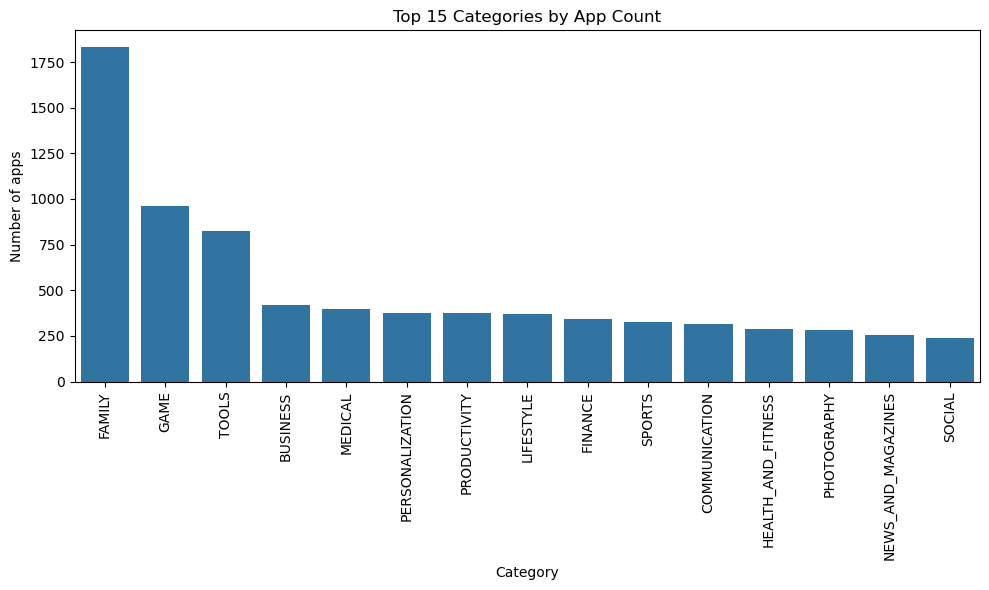

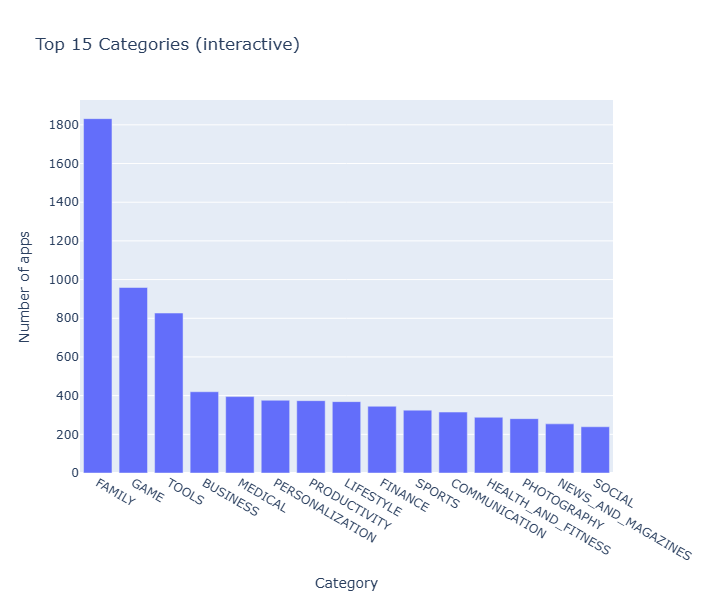

In [58]:
# --- Category exploration ---
if 'category' in apps.columns:
    cat_counts = apps['category'].value_counts(dropna=False)
    print('\nTop categories:')
    display(cat_counts.head(20))

    # Bar plot (top 15)
    top_cats = cat_counts.head(15)
    plt.figure(figsize=(10,6))
    sns.barplot(y=top_cats.values, x=top_cats.index)
    plt.title('Top 15 Categories by App Count')
    plt.xlabel('Category')
    plt.ylabel('Number of apps')
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()
 # Interactive bar
    fig = px.bar(x=top_cats.index, y=top_cats.values, orientation='v',
                labels={'x':'Category', 'y':'Number of apps'},
                title='Top 15 Categories (interactive)')
    fig.update_layout(height=600)
    fig.show()

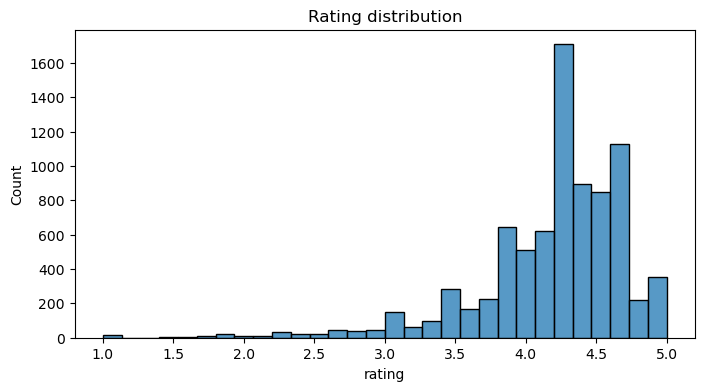

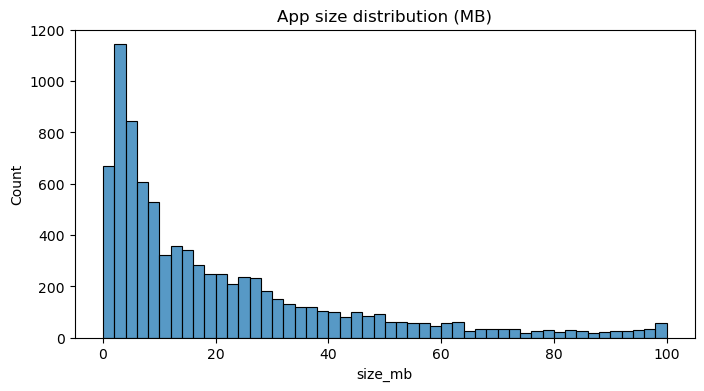


Price - free apps fraction:
92.17% free apps


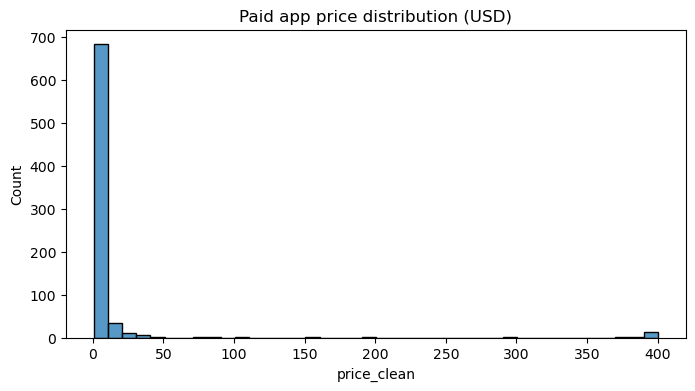

In [60]:
# Overall distributions
if 'rating' in apps.columns:
   plt.figure(figsize=(8,4))
   sns.histplot(apps['rating'].dropna(), bins=30)
   plt.title('Rating distribution')
   plt.show()
if 'size_mb' in apps.columns:
   plt.figure(figsize=(8,4))
   sns.histplot(apps['size_mb'].dropna(), bins=50)
   plt.title('App size distribution (MB)')
   plt.show()
# Price distribution
if 'price_clean' in apps.columns:
   print('\nPrice - free apps fraction:')
   free_frac = (apps['price_clean']==0).mean()
   print(f'{free_frac:.2%} free apps')
   plt.figure(figsize=(8,4))
   sns.histplot(apps.loc[apps['price_clean']>0,'price_clean'].dropna(), bins=40)
   plt.title('Paid app price distribution (USD)')
   plt.show()


Numeric cols for correlation: ['unnamed:_0', 'rating', 'reviews', 'size', 'installs_clean', 'price_clean', 'size_mb']


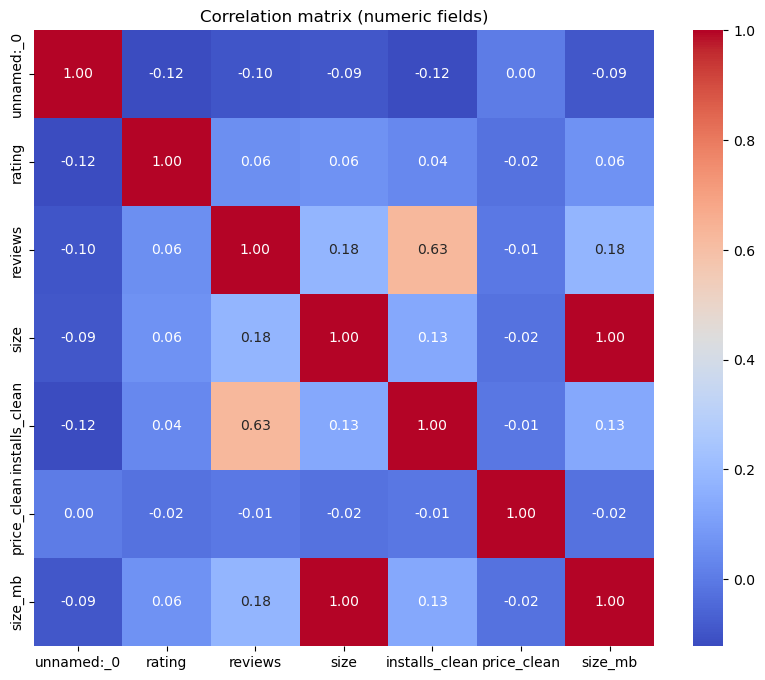

In [61]:
# --- Correlations and interesting checks ---
numeric_cols = apps.select_dtypes(include=[np.number]).columns.tolist()
print('\nNumeric cols for correlation:', numeric_cols)


if len(numeric_cols) > 1:
   corr = apps[numeric_cols].corr()
   plt.figure(figsize=(10,8))
   sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm')
   plt.title('Correlation matrix (numeric fields)')
   plt.show()


Running sentiment analysis on column: App


0    10 Best Foods for You
1    10 Best Foods for You
2    10 Best Foods for You
3    10 Best Foods for You
4    10 Best Foods for You
Name: App, dtype: object

sent_label
neutral     46334
positive    13781
negative     4180
Name: count, dtype: int64

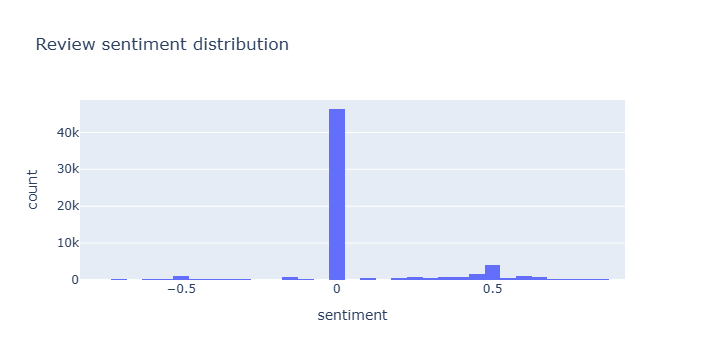

In [67]:
# --- Sentiment analysis on reviews (if a review text column exists) ---
# Heuristics to find review text column
review_text_col = None
for c in apps.columns:
    if 'review' in c and apps[c].dtype == object:
        review_text_col = c
        break
 # If reviews not in apps, maybe second file is reviews dataset
reviews_df = None
if review_text_col is None and df2 is not None and df2 is not apps:
    # try to detect a reviews table
    for df in [df2, df1]:
        if df is None:
           continue
        cols = ' '.join(df.columns).lower()
        if 'review' in cols or 'sentiment' in cols or 'content' in cols:
            reviews_df = df.copy()
            break

if review_text_col is not None:
   reviews_df = apps[[c for c in apps.columns if 'review' in c or 'comments' in c or 'content' in c]]


if reviews_df is not None and SentimentIntensityAnalyzer is not None:
   # try to find text column
   text_col = None
   for c in reviews_df.columns:
       if reviews_df[c].dtype == object:
          text_col = c
          break
   if text_col is not None:
       sia = SentimentIntensityAnalyzer()
       print('\nRunning sentiment analysis on column:', text_col)
       reviews_df = reviews_df.dropna(subset=[text_col])
       reviews_df['sentiment'] = reviews_df[text_col].apply(lambda t: sia.polarity_scores(str(t))['compound'])
       reviews_df['sent_label'] = reviews_df['sentiment'].apply(lambda s: 'positive' if s>0.05 else ('negative' if s<-0.05 else 'neutral'))
       display(reviews_df[text_col].head())
       display(reviews_df['sent_label'].value_counts())
    
       # basic plot
       fig = px.histogram(reviews_df, x='sentiment', nbins=50, title='Review sentiment distribution')
       fig.show()
   else:
        print('No textual review column found in detected reviews dataset.')
else:
    if reviews_df is None:
        print('\nNo reviews dataset detected. If you have a separate reviews CSV, place its path in file2 variable.')
    elif SentimentIntensityAnalyzer is None:
         print('\nVADER not available; please install nltk and download vader_lexicon to run sentiment analysis.')